Tests various Convolutional Neural Networks on and abridged version of the the Functional Map of the World dataset.

In [25]:
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

We will be using tensorflow-metal with tensorflow-macos to run on this device GPU.

In [26]:
# check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Tensorflow version:  2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Found 40012 files belonging to 10 classes.


2025-04-27 10:06:34.373069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


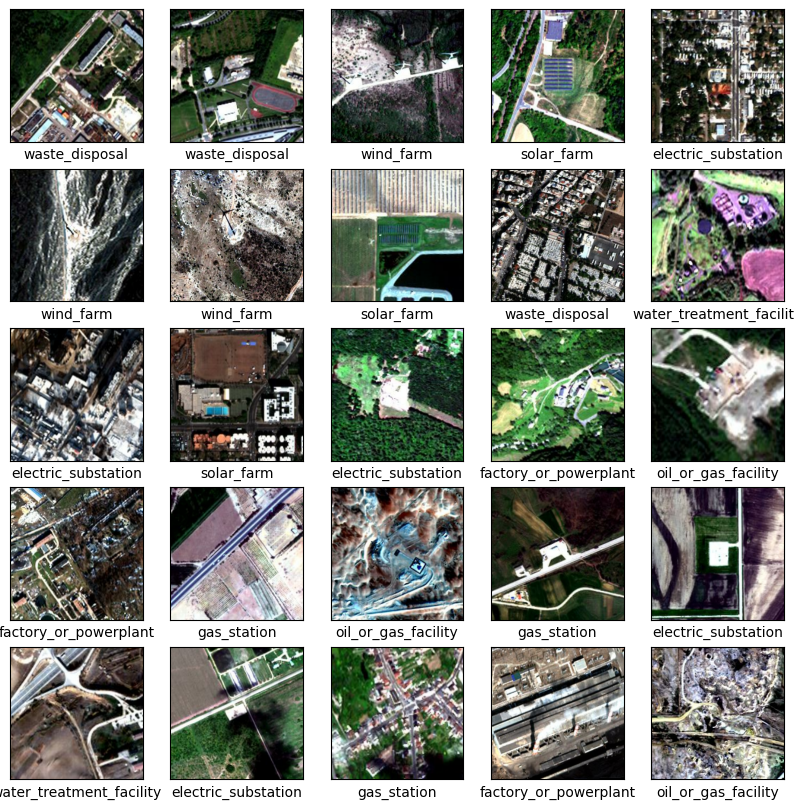

In [28]:
# we selected 10 or the original 63 classes from FMoW dataset
classes = [
    "electric_substation", "factory_or_powerplant", "gas_station",
    "nuclear_powerplant", "oil_or_gas_facility", "solar_farm", 
    "space_facility", "waste_disposal", "water_treatment_facility", "wind_farm"
]

dataset = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset/images/train',
    labels='inferred', # gets this from the folder structure
    label_mode='int', # with sparse_categorical_crossentropy
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# display a number of UNCROPPED images
class_names = dataset.class_names
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):

    # save this batch of images and labels for test use
    train_x_small = images
    train_y_small = labels

    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.xlabel(class_names[labels[i]])
plt.show()

Basically follow the HW 5.1.

First step: Build a basic model

In [29]:
# build a basic CNN model on uncropped images
test = models.Sequential()

# add convolutional base
test.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
test.add(layers.MaxPooling2D((2, 2)))
test.add(layers.Conv2D(64, (3, 3), activation='relu'))
test.add(layers.MaxPooling2D((2, 2)))

# feed last output tensor from convolutional base to Dense layers
test.add(layers.Conv2D(64, (3, 3), activation='relu'))

# flatten the 3D output to 1D
test.add(layers.Flatten())

# add two more Dense layers on top
test.add(layers.Dense(64, activation='relu'))
test.add(layers.Dense(32, activation='relu')) # bottleneck layer

# final Dense layer has 10 output units (one per class)
test.add(layers.Dense(10, activation='softmax'))

# view the model architecture
test.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,134,378 (42.47 MB)

 Trainable params: 11,134,378 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# compile with adam optimizer and SparseCategoricalCrossentropy loss function
test.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy']) 

# define Tensorboard callbacks
tb_cb = callbacks.TensorBoard('./logs', update_freq=1)
early_cb = callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=5)

# train the model to overfit on tiny data sample of 32 images
hist = test.fit(train_x_small, train_y_small, epochs=100, batch_size=4,
                validation_split=0.2,callbacks=[tb_cb, early_cb])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 3118.7170 - sparse_categorical_accuracy: 0.0507 - val_loss: 403.2534 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 221.6192 - sparse_categorical_accuracy: 0.0429 - val_loss: 114.9516 - val_sparse_categorical_accuracy: 0.4286
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 117.9158 - sparse_categorical_accuracy: 0.3995 - val_loss: 391.8931 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 134.3464 - sparse_categorical_accuracy: 0.3707 - val_loss: 232.3534 - val_sparse_categorical_accuracy: 0.1429
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 73.2803 - sparse_categorical_accuracy: 0.4126 - val_loss: 50.1144 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.6840 - sparse_categorical_accuracy: 0.9341 - val_loss: 67.7699 - val_sparse_categorical_

In [33]:
# view tensorboard localhost
!tensorboard --logdir=logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


The model was able to everfit pretty well with training sparse_categorical_accuracy of 0.9447 and val_sparse_categorical_accuracy of 0.1429 at Epoch 7. Let's see if we can do this with VGG architecture instead.

In [ ]:
# we're going to want different Tensorboard logs for each model to compare
tbcb_toy_vgg = callbacks.TensorBoard(log_dir='./logs/toy_vgg', update_freq='epoch')
tbcb_vgg = callbacks.TensorBoard(log_dir='./logs/vgg', update_freq='epoch')

In [ ]:
toy_vgg = models.Sequential()

# three groups of 2 conv 1 pool
toy_vgg.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
toy_vgg.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
toy_vgg.add(layers.MaxPooling2D((2, 2)))

toy_vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
toy_vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
toy_vgg.add(layers.MaxPooling2D((2, 2)))

toy_vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
toy_vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
toy_vgg.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output to 1D
toy_vgg.add(layers.Flatten())

# add one or more Dense layers on top
toy_vgg.add(layers.Dense(128, activation='relu'))
toy_vgg.add(layers.Dense(32, activation='relu')) # bottleneck layer
toy_vgg.add(layers.Dense(10, activation='softmax'))

# view the architecture
toy_vgg.summary()

/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,136,650 (50.11 MB)

 Trainable params: 13,136,650 (50.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile with adam optimizer and SparseCategoricalCrossentropy loss function
toy_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy']) 

# train the model to overfit on tiny data sample of 32 images
hist_toy_vgg = toy_vgg.fit(train_x_small, train_y_small, epochs=100, batch_size=4,
                validation_split=0.2,callbacks=[tbcb_toy_vgg, early_cb])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 933.5028 - sparse_categorical_accuracy: 0.0597 - val_loss: 211.5480 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 310.5965 - sparse_categorical_accuracy: 0.1080 - val_loss: 384.4770 - val_sparse_categorical_accuracy: 0.1429
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 323.1153 - sparse_categorical_accuracy: 0.2495 - val_loss: 109.3810 - val_sparse_categorical_accuracy: 0.1429
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 61.6899 - sparse_categorical_accuracy: 0.2505 - val_loss: 5.3785 - val_sparse_categorical_accuracy: 0.4286
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 2.5946 - sparse_categorical_accuracy: 0.2436 - val_loss: 2.2306 - val_sparse_categorical_accuracy: 0.1429
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 2.1399 - sparse_categorical_accuracy: 0.1158 - val_loss: 2.2026 - val_sparse_categorical_accuracy: 0.14

I am not achieving the same overfitting results as the simple model. I get sparse_categorical_accuracy 0.8497 and val_sparse_categorical_accuracy 0.2857 at Epoch 12, which seems to be my best. I don't think it gets better than that because VGG is too dense for such a small sample size. 

I will make some adjustments to the model before running on the full dataset.

In [50]:
# first, I want to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_cb = ModelCheckpoint(
    "best_model.h5",                # where to save
    monitor="val_sparse_categorical_accuracy", # what to watch
    mode="max",                      # maximize this metric
    save_best_only=True,             # only save when model is better
    verbose=1                        # show a message when saving
)

Tf image pipeline needs square images of the same size, so we specify (224, 224), just above (236, 161) that the msrgb images come in. Tf automatically resizes via aspect ratio distortion.

In [47]:
# load full training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset/images/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# load full validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset/images/val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123
)

Found 40012 files belonging to 10 classes.
Found 5671 files belonging to 10 classes.


Let's see how the VGG architecture performs when trained from scratch on the uncropped images only.

In [52]:
vgg = models.Sequential()

# three groups of 2 conv 1 pool
vgg.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
vgg.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
vgg.add(layers.MaxPooling2D((2, 2)))

vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg.add(layers.MaxPooling2D((2, 2)))

vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output to 1D
vgg.add(layers.Flatten())

# fully connected layers
vgg.add(layers.Dropout(0.5)) # add dropout to reduce overfitting
vgg.add(layers.Dense(128, activation='relu'))
vgg.add(layers.Dense(32, activation='relu')) 
vgg.add(layers.Dense(10, activation='softmax'))

# view the architecture
vgg.summary()

/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,136,650 (50.11 MB)

 Trainable params: 13,136,650 (50.11 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# compile with adam optimizer and SparseCategoricalCrossentropy loss function
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy']) 

vgg.fit(train_ds, validation_data=val_ds, epochs=30,
    callbacks=[tbcb_vgg, early_cb, best_model_cb])

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 1357.5814 - sparse_categorical_accuracy: 0.1196
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.15165, saving model to best_model.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 485s 386ms/step - loss: 1358.2896 - sparse_categorical_accuracy: 0.1196 - val_loss: 206.0837 - val_sparse_categorical_accuracy: 0.1516
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 170.8080 - sparse_categorical_accuracy: 0.1253
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.15165
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 493s 394ms/step - loss: 170.7774 - sparse_categorical_accuracy: 0.1253 - val_loss: 61.9583 - val_sparse_categorical_accuracy: 0.1388
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 110.5982 - sparse_categorical_accuracy: 0.1253
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.15165
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 543s 434ms/step - loss: 110.5887 - sparse_categorical_accuracy: 0.1253 - val_loss: 28.5261 - val_sparse_categorical_accuracy: 0.1132
Epoch 4/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 280.9754 - sparse_categorical_accuracy: 0.1202
Epoch 4: val_sparse_categorical_a

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 574s 459ms/step - loss: 30160.2871 - sparse_categorical_accuracy: 0.1253 - val_loss: 139513.3281 - val_sparse_categorical_accuracy: 0.1566
Epoch 6/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 2799345.7500 - sparse_categorical_accuracy: 0.1388
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.15659
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 539s 431ms/step - loss: 2804634.0000 - sparse_categorical_accuracy: 0.1388 - val_loss: 10327329.0000 - val_sparse_categorical_accuracy: 0.1233
Epoch 7/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 8049415.5000 - sparse_categorical_accuracy: 0.1307
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.15659
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 546s 437ms/step - loss: 8048619.0000 - sparse_categorical_accuracy: 0.1307 - val_loss: 9926352.0000 - val_sparse_categorical_accuracy: 0.1502
Epoch 8/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 12619038.0000 - sparse_categorical_accuracy: 0.14

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 546s 436ms/step - loss: 12617422.0000 - sparse_categorical_accuracy: 0.1454 - val_loss: 10851420.0000 - val_sparse_categorical_accuracy: 0.1636
Epoch 9/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 21685188.0000 - sparse_categorical_accuracy: 0.1490
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.16364
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 575s 460ms/step - loss: 21689966.0000 - sparse_categorical_accuracy: 0.1490 - val_loss: 23886620.0000 - val_sparse_categorical_accuracy: 0.1402
Epoch 10/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 54028064.0000 - sparse_categorical_accuracy: 0.1458
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.16364
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 619s 494ms/step - loss: 54069664.0000 - sparse_categorical_accuracy: 0.1458 - val_loss: 217464864.0000 - val_sparse_categorical_accuracy: 0.1536
Epoch 11/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 220131456.0000 - sparse_categorical

In [57]:
!tensorboard --logdir=logs/vgg

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


That took about 10 min per Epoch, and hit the early stopping callback at Epoch 13 (123 minutes totalruntime). It made me realize I should update the early stopping callback to use val_sparse_categorical_accuracy and restore the best weights to the saved variable, not just the saved model. Looking at the Tensorboard, it seems like the accuracy peaked at Epoch 8 with 0.1454 sparse_catagorical_accuracy and 0.16364 val_sparse_categorical_accuracy. Then both accuracies started going down, indicative of overfitting.

We can check the test accuracy when we have the test folders organized. We just need to load "best_model.h5".

In [ ]:
# scratch_vgg = tf.keras.models.load_model('best_model.h5')
# test_loss, test_accuracy = scratch_vgg.evaluate(test_ds)
# print(f"Test Accuracy: {test_accuracy:.4f}")

Now let's see how much better it is to use the VGG architecture pretrained on ImageNet instead of the scratch training.

In [60]:
# start with VGG16, try also VGG19 (then ResNet50, ResNet151, DenseNet161)
from tensorflow.keras.applications import VGG16

# load the VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))

# freeze the base model to maximize training on the new dataset
base_model.trainable = False
vgg16 = models.Sequential()
vgg16.add(base_model)   

# then add your own classifier on top
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(256, activation='relu'))
vgg16.add(layers.Dense(32, activation='relu'))
vgg16.add(layers.Dense(10, activation='softmax'))

# compile the model
vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

# update callbacks
tbcb_vgg16 = callbacks.TensorBoard(log_dir='./logs/vgg16', update_freq='epoch')
early_cb = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   patience=5, restore_best_weights=True)
best_model_cb = ModelCheckpoint("vgg16_best.keras", # updated file format
                    monitor="val_sparse_categorical_accuracy", mode="max",
                    save_best_only=True, verbose=1, save_traces=False)

# train the model on fmow msrgb dataset
vgg16.fit(train_ds, validation_data=val_ds, epochs=30,
    callbacks=[tbcb_vgg16, early_cb, best_model_cb])

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - loss: 82.8917 - sparse_categorical_accuracy: 0.4131
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.46112, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 979s 782ms/step - loss: 82.8742 - sparse_categorical_accuracy: 0.4132 - val_loss: 74.5301 - val_sparse_categorical_accuracy: 0.4611
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - loss: 41.4394 - sparse_categorical_accuracy: 0.6050
Epoch 2: val_sparse_categorical_accuracy improved from 0.46112 to 0.49621, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1021s 816ms/step - loss: 41.4380 - sparse_categorical_accuracy: 0.6050 - val_loss: 69.5297 - val_sparse_categorical_accuracy: 0.4962
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - loss: 38.8512 - sparse_categorical_accuracy: 0.6627
Epoch 3: val_sparse_categorical_accuracy improved from 0.49621 to 0.51966, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1025s 819ms/step - loss: 38.8494 - sparse_categorical_accuracy: 0.6627 - val_loss: 89.6628 - val_sparse_categorical_accuracy: 0.5197
Epoch 4/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - loss: 39.5054 - sparse_categorical_accuracy: 0.7103
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.51966
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1017s 813ms/step - loss: 39.5040 - sparse_categorical_accuracy: 0.7103 - val_loss: 121.0992 - val_sparse_categorical_accuracy: 0.5123
Epoch 5/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 40.0657 - sparse_categorical_accuracy: 0.7412
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.51966
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1030s 823ms/step - loss: 40.0636 - sparse_categorical_accuracy: 0.7413 - val_loss: 151.2856 - val_sparse_categorical_accuracy: 0.5165
Epoch 6/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - loss: 39.3600 - sparse_categorical_accuracy: 0.7762
Epoch 6: val_sparse_categorical_accu

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1024s 818ms/step - loss: 39.3608 - sparse_categorical_accuracy: 0.7762 - val_loss: 184.3947 - val_sparse_categorical_accuracy: 0.5302
Epoch 7/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - loss: 36.9573 - sparse_categorical_accuracy: 0.8045
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.53024
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1022s 817ms/step - loss: 36.9567 - sparse_categorical_accuracy: 0.8045 - val_loss: 209.1798 - val_sparse_categorical_accuracy: 0.5200
Epoch 8/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - loss: 36.7959 - sparse_categorical_accuracy: 0.8169
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.53024
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1107s 885ms/step - loss: 36.7971 - sparse_categorical_accuracy: 0.8169 - val_loss: 233.2569 - val_sparse_categorical_accuracy: 0.5001
Epoch 9/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - loss: 44.1401 - sparse_categorical_accuracy: 0.8120
Epoch 9: val_sparse_categorical_acc

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 996s 796ms/step - loss: 48.5979 - sparse_categorical_accuracy: 0.8208 - val_loss: 342.5235 - val_sparse_categorical_accuracy: 0.5345
Epoch 11/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - loss: 56.3635 - sparse_categorical_accuracy: 0.8189
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.53447
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 903s 722ms/step - loss: 56.3637 - sparse_categorical_accuracy: 0.8189 - val_loss: 417.9865 - val_sparse_categorical_accuracy: 0.5089
Epoch 12/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 62.5799 - sparse_categorical_accuracy: 0.8311
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.53447
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 886s 708ms/step - loss: 62.5799 - sparse_categorical_accuracy: 0.8311 - val_loss: 480.7057 - val_sparse_categorical_accuracy: 0.5112
Epoch 13/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - loss: 66.8692 - sparse_categorical_accuracy: 0.8407
Epoch 13: val_sparse_categorical_

In [ ]:
!tensorboard --logdir=logs/vgg16

That took about 15 min per epoch

Let's define a function to run all pretrained models on the same additional architecture as above.

In [61]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

def build_and_train_model(model_fn, name, train_ds, val_ds, num_classes=10, epochs=30):

    # 1. load and freeze the base model
    base_model = model_fn(weights='imagenet', include_top=False, 
                               input_shape=(224, 224, 3))
    base_model.trainable = False

    # 2. build the full model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 3. Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = TensorBoard(log_dir=f'./logs/{name}', update_freq='epoch')
    best_model_cb = ModelCheckpoint( f'{name}_best.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb])

    return model, history


In [ ]:
from tensorflow.keras.applications import VGG19
vgg19_model, vgg19_history = build_and_train_model(VGG19, 'vgg19', 
                                train_ds, val_ds, num_classes=10, epochs=30)

In [ ]:
!tensorboard --logdir=logs/vgg19

In [62]:
from tensorflow.keras.applications import ResNet50
resnet50_model, resnet50_history = build_and_train_model(ResNet50, 'resnet50', 
                                train_ds, val_ds, num_classes=10, epochs=30)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 56.4368 - sparse_categorical_accuracy: 0.4332
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.52795, saving model to resnet50_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 736s 584ms/step - loss: 56.4164 - sparse_categorical_accuracy: 0.4333 - val_loss: 18.9707 - val_sparse_categorical_accuracy: 0.5279
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 17.1707 - sparse_categorical_accuracy: 0.6439
Epoch 2: val_sparse_categorical_accuracy improved from 0.52795 to 0.54929, saving model to resnet50_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 727s 581ms/step - loss: 17.1678 - sparse_categorical_accuracy: 0.6439 - val_loss: 21.9079 - val_sparse_categorical_accuracy: 0.5493
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 9.4871 - sparse_categorical_accuracy: 0.7428
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.54929
1251

In [ ]:
!tensorboard --logdir=logs/resnet50

In [ ]:
from tensorflow.keras.applications import ResNet152
resnet152_model, resnet152_history = build_and_train_model(ResNet152, 'resnet152', 
                                train_ds, val_ds, num_classes=10, epochs=30)

In [ ]:
!tensorboard --logdir=logs/resnet152

In [ ]:
from tensorflow.keras.applications import DenseNet161
dense161_model, dense161_history = build_and_train_model(DenseNet161, 'dense161', 
                                train_ds, val_ds, num_classes=10, epochs=30)

We could get into unfreezing the base models.